## Benchmark: `tensorfy` versus Quimb

We start by implementing a class `CircuitGenerator` that generates a ZX circuit in the form of a graph. There are two main methods that we use: the first is to simply call the method `CNOT_HAD_PHASE_circuit` from PyZX library, and the other generates multiple layers, each one consisting of CZ gates and two Z spiders on the first line with random phases. The latter has the effect of producing dense graphs.

In [1]:
import sys; sys.path.append('..')
import matplotlib.pyplot as plt
import numpy as np
import pyzx as zx
import time
import random
from fractions import Fraction
from tqdm import tqdm
%matplotlib inline

In [2]:
class CircuitGenerator:
    def __init__(self, qubits: int, depth: int, dense: bool = False):
        assert qubits > 0, "The number of qubits must be positive."
        assert depth > 0, "The depth must be positive."
        self.__dense = dense
        self.__qubits = qubits
        self.__depth = depth

    def __call__(self) -> zx.graph.base.BaseGraph:
        if self.__dense:
            return self.__dense_graph(qubits = self.__qubits, layers_count = self.__depth)
        else:
            return zx.generate.CNOT_HAD_PHASE_circuit(qubits = self.__qubits,
                                                      depth = self.__depth,
                                                      clifford = False).to_graph()

    def __dense_graph(self, qubits, layers_count: int = 10) -> zx.graph.base.BaseGraph:
        g = zx.Graph()
        inputs = [g.add_vertex(zx.VertexType.BOUNDARY, qubit = i, row = 0)
                  for i in range(qubits)]
        outputs = [g.add_vertex(zx.VertexType.BOUNDARY, qubit = i, row = 4 * layers_count + 1)
                   for i in range(qubits)]

        # This local function adds a new layer having a particular shape;
        # we need the previous `qubits` nodes along each line, together with the
        # index `cnt` of the layer we need to construct.
        # It returns the new last vertex on each line.
        def add_layer(prev, cnt):
            # Create the vertices.
            layer = [g.add_vertex(zx.VertexType.Z,
                            qubit = (i + 1) // 2,
                            row = 4 * cnt + (1 if i % 4 < 2 else 2)) for i in range(2 * qubits - 2)]
            # Construct the edges between these `2 * qubits - 2` vertices in a zig-zag shape.
            H, S = zx.EdgeType.HADAMARD, zx.EdgeType.SIMPLE
            for i in range(2 * qubits - 3):
                g.add_edge(g.edge(layer[i], layer[i + 1]), edgetype = H if i % 2 == 0 else S)

            # We collect the first (front) and the last (end) vertex on each of the `qubits` lines.
            front_indices, end_indices = [], []
            front_indices.append(0)
            end_indices.append(0)
            for i in range(1, qubits - 1):
                front_indices.append(2 * i - (i & 1))
                end_indices.append(2 * i - (i + 1 & 1))
            front_indices.append(2 * qubits - 3)
            end_indices.append(2 * qubits - 3)

            # Connect the previous layer (or the inputs if this is to be the first one)
            # to the current layer.
            for i in range(qubits):
                g.add_edge(g.edge(prev[i], layer[front_indices[i]]), zx.EdgeType.SIMPLE)

            # Add two randomised red vertices along each wire:
            # Their phases are k * pi / 4 and l * pi / 4, where k and l are independent
            # and uniformly distributed over {0, 1, ..., 7}.
            prev = []
            for i in range(qubits):
                [k, l] = [g.add_vertex(zx.VertexType.X,
                                       phase = Fraction(random.randrange(8), 4),
                                       qubit = i,
                                       row = 4 * cnt + j + 3) for j in range(2)]
                g.add_edge(g.edge(layer[end_indices[i]], k), edgetype = zx.EdgeType.SIMPLE)
                g.add_edge(g.edge(k, l), edgetype = zx.EdgeType.SIMPLE)
                prev.append(l)
            return prev

        # Add all layers whilst updating the prev vertices.
        prev = inputs
        for cnt in range(layers_count):
            prev = add_layer(prev, cnt)

        # Connect the prev vertices with the outputs.
        for i in range(qubits):
            g.add_edge(g.edge(prev[i], outputs[i]), zx.EdgeType.SIMPLE)

        # Set the inputs and outputs
        g.auto_detect_io()
        return g

Now we implement a class `RandomCircuitBenchmark` which performs time profiling of `tensorfy` and Quimb's tensor contraction routines:
* The constructor sets up fields `repeat` for the number of circuits to be averaged in one go, `dense` flag which specifies whether dense graphs are to be used or not, and `full_reduce` which specifies whether the function with the same name from `PyZX` ought to be used before converting the diagrams to circuits. Additionally, we specify which simulation strategies are to be executed for both `tensorfy` and Quimb.
* A private method `run_tensor` is used to generate a circuit, convert it to a graph, use kets 0 as inputs and bras 0 as outputs, and measure the execution time of each routine on this diagram.
* Another private method `run_tensors` simply calls `run_tensor` multiple (`repeat`) times and returns the average time of each strategy.
* A public method `run_with_qubits`, which takes the depth and the range of qubits as inputs, returns the execution time of each strategy for every qubit configuration.
* A public method `run_with_depths` is the same as before, but varies the circuit depth while fixing the qubit count.
* A public method `display_plot` plotting the performance of each strategy.
* A static method `get_table`, which returns the execution times in the form of a table.
* A public method `display_table_and_plot` which both prints the table and plots the data.

In [3]:
class RandomCircuitBenchmark:
    def __init__(self, repeat: int = 10, dense: bool = False, full_reduce: bool = False,
                 tensorfy_strategies = ('naive', 'rw-greedy-b2t', 'rw-greedy-linear'),
                 quimb_strategies = ('hyper-greedy', 'hyper-kahypar', 'optimal')):
        self.__repeat = repeat
        self.__dense = dense
        self.__full_reduce = full_reduce
        self.__tensorfy_strategies = tensorfy_strategies
        self.__quimb_strategies = quimb_strategies
        self.__all_strategies = self.__tensorfy_strategies + ('quimb',) + self.__quimb_strategies

    def run_with_qubits(self, depth, qubits_range):
        times_dict = {strategy: [] for strategy in self.__all_strategies}
        self.__depth = depth
        for qubits in tqdm(qubits_range):
            self.__qubits = qubits
            self.__generator = CircuitGenerator(qubits, depth, self.__dense)
            time_dict = self.__run_tensors()
            for strategy in time_dict.keys():
                times_dict[strategy].append(time_dict[strategy])
        return times_dict

    def run_with_depths(self, qubits, depth_range):
        times_dict = {strategy: [] for strategy in self.__all_strategies}
        self.__qubits = qubits
        for depth in tqdm(depth_range):
            self.__depth = depth
            self.__generator = CircuitGenerator(qubits, depth, self.__dense)
            time_dict = self.__run_tensors()
            for strategy in time_dict.keys():
                times_dict[strategy].append(time_dict[strategy])
        return times_dict

    def __run_tensor(self):
        # Generate a circuit and convert it to a graph object
        g = self.__generator()
        g.apply_state("0" * self.__qubits)  # use kets 0 as inputs
        g.apply_effect("0" * self.__qubits)  # use bras 0 as outputs
        zx.to_gh(g)  # get rid of red spiders
        if self.__full_reduce:
            zx.full_reduce(g)

        value_dict = dict()
        time_dict = dict()
        
        # Profiling tensorfy strategies
        for strategy in self.__tensorfy_strategies:
            t = time.time()
            value_dict[strategy] = g.to_tensor(strategy=strategy)
            time_dict[strategy] = time.time() - t

        # Profiling basic quimb
        t = time.time()
        value_dict['quimb'] = zx.to_quimb_tensor(g).contract(output_inds=())
        time_dict['quimb'] = time.time() - t

        # Profiling quimb strategies
        for strategy in self.__quimb_strategies:
            t = time.time()
            tn = zx.to_quimb_tensor(g)
            tn.full_simplify_('ADCRS', output_inds = (), equalize_norms = True)
            value_dict[strategy] = tn.contract(optimize = strategy, output_inds = ())
            time_dict[strategy] = time.time() - t

        # Assert correctness and update the list fields.
        for strategy in self.__tensorfy_strategies:
            assert abs(value_dict[strategy] - value_dict['quimb']) < 1e-9, f"Tensorfy ({strategy}) produces incorrect result"
        for strategy in self.__quimb_strategies:
            assert abs(value_dict[strategy] - value_dict['quimb']) < 1e-9, f"Quimb ({strategy}) produces incorrect result"
        for strategy in time_dict.keys():
            self.__times_dict[strategy].append(time_dict[strategy])

    def __run_tensors(self):
        self.__times_dict = {strategy: [] for strategy in self.__all_strategies}
        for _ in range(self.__repeat):
            self.__run_tensor()
        return {strategy: np.mean(self.__times_dict[strategy]) for strategy in self.__times_dict.keys()}

    def display_plot(self, times_dict, rng, has_qubits: bool):
        var_type, fixed_type, fixed_quant = ("qubits", "depth", self.__depth) if has_qubits else \
            ("depth", "qubits", self.__qubits)
        fig, ax = plt.subplots()
        for strategy in self.__tensorfy_strategies:
            ax.plot(rng, times_dict[strategy], label=f'Tensorfy ({strategy})')
        ax.plot(rng, times_dict['quimb'], label=f'Quimb (basic)')
        for strategy in self.__quimb_strategies:
            ax.plot(rng, times_dict[strategy], '--', label=f'Quimb ({strategy})')
        ax.set_yscale('log')
        ax.set_xlabel(var_type)
        ax.set_ylabel("time (s)")
        ax.set_title(f"From {rng[0]} to {rng[-1]} {var_type}, fixed {fixed_type} of {fixed_quant}")
        ax.legend()

    def get_table(self, var, range_var, times_dict):
        def list_to_row(name, elems):
            s = name.ljust(15)
            is_first = True
            for x in elems:
                if is_first:
                    is_first = False
                else:
                    s += " | "
                s += str(x).rjust(7) if isinstance(x, int) else "{:.3f}".format(x).rjust(7)
            s += '\n'
            return s

        s = list_to_row(f"{var}:", range_var)
        for strategy in self.__tensorfy_strategies:
            s += list_to_row(f"Tensorfy ({strategy}) times:", times_dict[strategy])
        s += list_to_row("Quimb (basic) times:", times_dict['quimb'])
        for strategy in self.__quimb_strategies:
            s += list_to_row(f"Quimb ({strategy}) times:", times_dict[strategy])
        return s

    def display_table_and_plot(self, times_dict, rng, has_qubits: bool):
        var_type, fixed_type, fixed_quant = ("Qubits", "depth", self.__depth) if has_qubits else \
            ("Depth", "qubits", self.__qubits)
        str_full_reduce = " (with full_reduce = True)" if self.__full_reduce else ""
        print(f"For {fixed_quant} {fixed_type}{str_full_reduce}:\n")
        print(self.get_table(var_type, rng, times_dict))
        self.display_plot(times_dict, rng, has_qubits)

    def test(self, has_qubits: bool, fixed_quant: int, rng, with_table: bool = False):
        times_dict = self.run_with_qubits(fixed_quant, rng) if has_qubits \
            else self.run_with_depths(fixed_quant, rng)
        if with_table:
            self.display_table_and_plot(times_dict, rng, has_qubits)
        else:
            self.display_plot(times_dict, rng, has_qubits)

We first compare `tensorfy` against Quimb by fixing the depth and varying the number of qubits, while `dense` and `full_reduce` are, by default, `False`:

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:14<00:00,  1.29it/s]


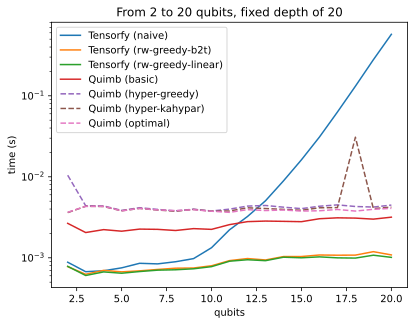

In [14]:
cb = RandomCircuitBenchmark()
cb.test(has_qubits = True, fixed_quant = 20, rng = range(2, 21))

The time for contracting the tensor network with the naive strategy increases exponentially with the number of qubits when the depth is fixed, while the Quimb's contraction time stays roughly the same. Yet the rank-width-based strategies outperform Quimb by a factor of 3 on all instances.

Let us now fix the number of qubits and vary the circuit depth:

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.31it/s]


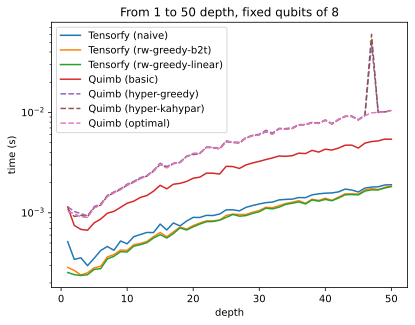

In [15]:
cb = RandomCircuitBenchmark()
cb.test(has_qubits = False, fixed_quant = 8, rng = range(1, 51))

As the depth increases and the number of qubits stays fixed, both `tensorfy` and Quimb seem to perform the same up to a constant factor -- the `tensorfy` strategies are all consistently 3 times faster. The advanced Quimb optimisers perform worse than the baseline, especially for larger depths.

Let us compare the performance of `tensorfy` on larger depths, where the asymptotic complexity of tensor contraction comes into play.

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [01:34<00:00,  1.90s/it]


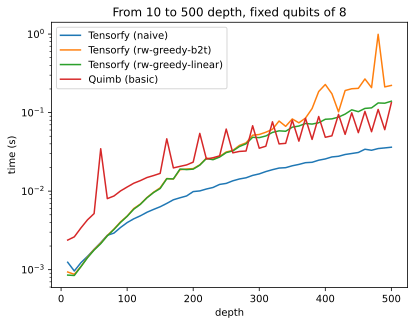

In [16]:
cb = RandomCircuitBenchmark(quimb_strategies = ())
cb.test(has_qubits = False, fixed_quant = 8, rng = range(10, 501, 10))

We see that naive `tensorfy` is still 3 times faster than the baseline, but the rank-width approach starts to deviate: the `rw-greedy-linear` strategy levels off with the basic Quimb optimiser for large depths, while `rw-greedy-b2t` becomes even worse.

We now repeat the same experiments but with `full_reduce = True`:

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 39.17it/s]


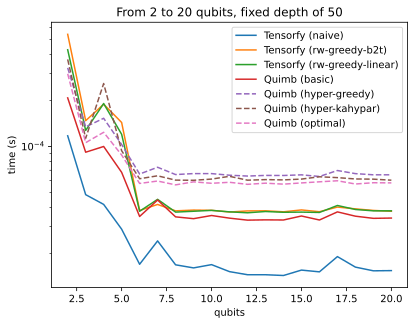

In [17]:
cb = RandomCircuitBenchmark(full_reduce = True)
cb.test(has_qubits = True, fixed_quant = 50, rng = range(2, 21))

The times are now negligible, because the graphs are reduced to simple scalars.

Varying the depth up to 80 for 5 qubits leads to small `tensorfy` times as well, but with the occasional spikes for the advanced Quimb strategies: 

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:04<00:00,  8.40it/s]


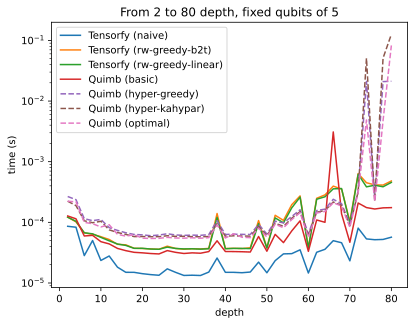

In [18]:
cb = RandomCircuitBenchmark(full_reduce = True)
cb.test(has_qubits = False, fixed_quant = 5, rng = range(2, 81, 2))

Discarding the advanced Quimb optimisers, we proceed to increase the depth:

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:50<00:00,  1.69s/it]


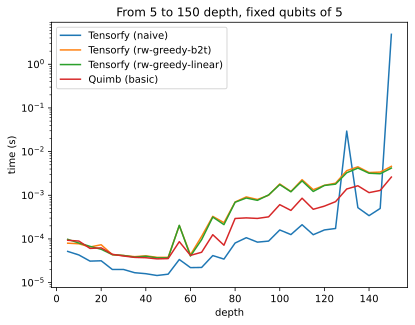

In [19]:
cb = RandomCircuitBenchmark(quimb_strategies=(), full_reduce = True)
cb.test(has_qubits = False, fixed_quant = 5, rng = range(5, 151, 5))

We observe that for depths ~150 the naive `tensorfy` starts to blow up, while both rank-width strategies remain close to Quimb. If we keep increasing the depth, at some point Quimb starts to slow down as well, while the rank-width routines behave more reliably:

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [01:22<00:00,  1.37s/it]


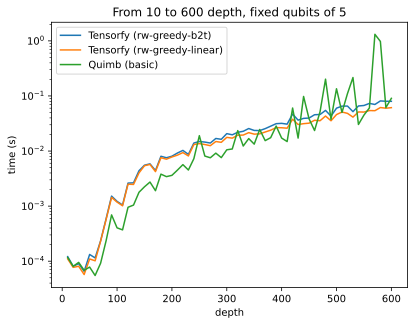

In [6]:
cb = RandomCircuitBenchmark(quimb_strategies=(), tensorfy_strategies = ('rw-greedy-b2t', 'rw-greedy-linear'), full_reduce = True)
cb.test(has_qubits = False, fixed_quant = 5, rng = range(10, 601, 10))

Now we do some experiments with dense graphs. Even for very small configurations advanced Quimb strategies behave terribly:

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.54it/s]


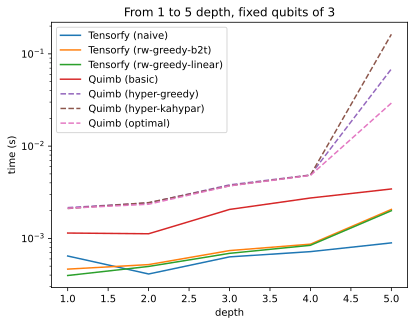

In [8]:
cb = RandomCircuitBenchmark(dense = True)
cb.test(has_qubits = False, fixed_quant = 3, rng = range(1, 6))

Running the remaining routines on larger instances, we see again the naive `tensorfy` outperforms Quimb and rank-width on the majority of samples:

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [04:50<00:00,  5.81s/it]


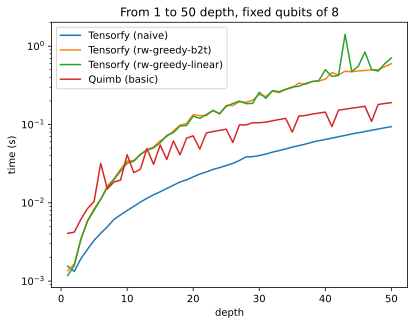

In [9]:
cb = RandomCircuitBenchmark(quimb_strategies = (), dense = True)
cb.test(has_qubits = False, fixed_quant = 8, rng = range(1, 51))

To sum up, the default naive `tensorfy` performs quite well on random circuits. Its limitations are revealed in the following cases:
1. for `full_reduce = False`: wide circuits (with large qubit count and small depth),
2. for `full_reduce = True`: deep circuits (with large depth and small qubit count).

The strategies based on rank-width perform more reliably, with the only exception of `rw-greedy-b2t` run on very deep circuits.